<a href="https://colab.research.google.com/github/ikyath/CardioVascularDiseaseDetection/blob/master/Cardiovascular_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pwd


'/content'

In [2]:
ls

drive/  sample_data/


In [3]:
cd /content/drive/My\ Drive/Data\ Science/Hackathon

/content/drive/My Drive/Data Science/Hackathon


Import necessary libraries

In [0]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from xgboost import XGBClassifier
import pickle



## EDA

In [0]:
train = pd.read_csv('cardio_train.csv',sep=';')

In [6]:
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


We will drop id column as it is insignificant 

In [0]:
train = train.drop('id',axis=1)

In [8]:
train.shape

(69301, 12)

In [9]:
train.tail()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69296,19240,2,168,76.0,120,80,1,1,1,0,1,0
69297,22601,1,158,126.0,140,90,2,2,0,0,1,1
69298,19066,2,183,105.0,180,90,3,1,0,1,0,1
69299,22431,1,163,72.0,135,80,1,2,0,0,0,1
69300,20540,1,170,72.0,120,80,2,1,0,0,1,0


There are total 69301 records of data with 12 features

Lets look into datatypes of each column

In [10]:
train.describe(percentiles=[0.01,.10,.50,.80,0.99])

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1%,14466.000000,1.000000,147.000000,48.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
10%,15839.000000,1.000000,155.000000,58.000000,110.000000,70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
80%,21849.000000,2.000000,170.000000,85.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
99%,23489.000000,2.000000,184.000000,117.000000,180.000000,1000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


From the above data we can see the outliers lie are in less than 1%

Lets try to build a model without outliers

In [0]:
train = train.drop(train[(train.height<147) | (train.height>184)].index)
train = train.drop(train[(train.weight<48) | (train.weight>117)].index)

Lets see outliers more clearly

Lets check for duplicate records

In [12]:
train.duplicated().sum()

24

Lets remove duplicated rows

In [13]:
train.drop_duplicates(inplace=True)
print(train.shape)

(66823, 12)


In [14]:
train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,23393,1,155,62.0,120,80,1,1,0,0,1,0


 Number of Patients

In [15]:
train.shape[0]

66823

Lets convert age from days to years apxt

In [0]:
train.age = train.age.apply(lambda x:x/365)

In [17]:
train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,61.558904,1,155,69.0,130,80,2,2,0,0,1,0
1,40.131507,1,163,71.0,110,70,1,1,0,0,1,1
2,60.002740,1,165,70.0,120,80,1,1,0,0,1,0
3,39.860274,2,165,85.0,120,80,1,1,1,1,1,0
4,64.090411,1,155,62.0,120,80,1,1,0,0,1,0


 Check for any duplicate entries of patients based on id

In [18]:
train.gluc.value_counts()

1    56865
3     5064
2     4894
Name: gluc, dtype: int64

In [19]:
train.smoke.value_counts()

0    60974
1     5849
Name: smoke, dtype: int64

In [20]:
train.alco.value_counts()

0    63246
1     3577
Name: alco, dtype: int64

In [21]:
train.active.value_counts()

1    53751
0    13072
Name: active, dtype: int64

The dataset to be classified as target variable is balanced.

In [22]:
train.cardio.value_counts()

0    33481
1    33342
Name: cardio, dtype: int64

In [0]:
s_list = ["age", "height", "weight", "ap_hi", "ap_lo"]
def standartization(x):
    x_std = x.copy(deep=True)
    for column in s_list:
        x_std[column] = (x_std[column]-x_std[column].mean())/x_std[column].std()
    return x_std 
train_std=standartization(train)
train_std.head()
train=train_std

In [24]:
train.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,1.216151,1,-1.292653,-0.376981,0.007414,-0.087351,2,2,0,0,1,0
1,-1.959038,1,-0.199537,-0.222296,-0.119559,-0.140869,1,1,0,0,1,1
2,0.985553,1,0.073741,-0.299638,-0.056072,-0.087351,1,1,0,0,1,0
3,-1.999231,2,0.073741,0.860495,-0.056072,-0.087351,1,1,1,1,1,0
4,1.591279,1,-1.292653,-0.918376,-0.056072,-0.087351,1,1,0,0,1,0


In [0]:
features=["age", "height", "weight",'ap_hi','ap_lo','smoke','alco','active','cholesterol','gluc']

In [0]:
features_vif=["age", "height", "weight",'ap_hi','ap_lo','smoke','alco','active','cardio','cholesterol','gluc']

In [0]:
# scaler = StandardScaler().fit(train[features])
# df_rescaled = scaler.transform(train[features])

X_train, X_test, y_train, y_test = train_test_split(train[features], train['cardio'], test_size=0.33, random_state=42)

In [0]:
logml = sm.GLM(y_train,(sm.add_constant(X_train)),family = sm.families.Binomial())


In [29]:
X_train.head()

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol,gluc
56510,-0.877095,1.850054,0.473784,-0.056072,-0.087351,0,0,1,1,1
38790,0.972156,0.620299,-0.454323,0.070901,-0.033833,0,0,0,1,1
54598,-1.373206,0.483660,1.865944,0.070901,-0.033833,0,0,1,1,1
23435,1.558801,-0.746095,0.009731,-0.056072,-0.087351,0,0,1,1,1
13149,0.326644,0.347020,0.705811,-0.024329,-0.140869,0,0,1,2,1


In [30]:
logml.fit().summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:943: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/usr/local/lib/python3.6/dist-packages/statsmodels/ge

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 cardio   No. Observations:                44771
Model:                            GLM   Df Residuals:                    44760
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 13 May 2020   Deviance:                          nan
Time:                        23:03:47   Pearson chi2:                 1.39e+16
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2623      0.036     -7.343      0.000      -0.332      -0.192
age             0.3666      0.011     33.415      0.000       0.345       0.388
height         -0.0336      0.011     -2.966      0.003      -0.056      -0.011
weight          0.2214      0.012     19.034      0.000       0.199       0.244
ap_hi           6.3779      0.121     52.755      0.000       6.141       6.615
ap_lo           0.0657      0.018      3.642      0.000       0.030       0.101
smoke          -0.2008      0.040     -4.999      0.000      -0.280      -0.122
alco           -0.1724      0.051     -3.398      0.001      -0.272      -0.073
active         -0.1935      0.026     -7.345      0.000      -0.245      -0.142
cholesterol     0.5264      0.019     27.984      0.000       0.490       0.563
gluc           -0.1305      0.021     -6.124      0.000      -0.172      -0.089
===============================================================================
"""

In [0]:
def vif_cal(input_data,dependent_col):
    vif_df=pd.DataFrame( columns = ['Var','Vif'])
    x_vars=input_data.drop([dependent_col],axis=1)
    xvar_names = x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-rsq),2)
        vif_df.loc[i]=[xvar_names[i],vif]
    return vif_df.sort_values(by='Vif', axis=0, ascending=False,inplace=False)

In [32]:
vif_cal(input_data=train[features_vif],dependent_col="cardio")

,Var,Vif
9,gluc,5.78
8,cholesterol,5.72
7,active,3.30
5,smoke,1.28
6,alco,1.20
1,height,1.15
2,weight,1.12
0,age,1.03
3,ap_hi,1.00
4,ap_lo,1.00


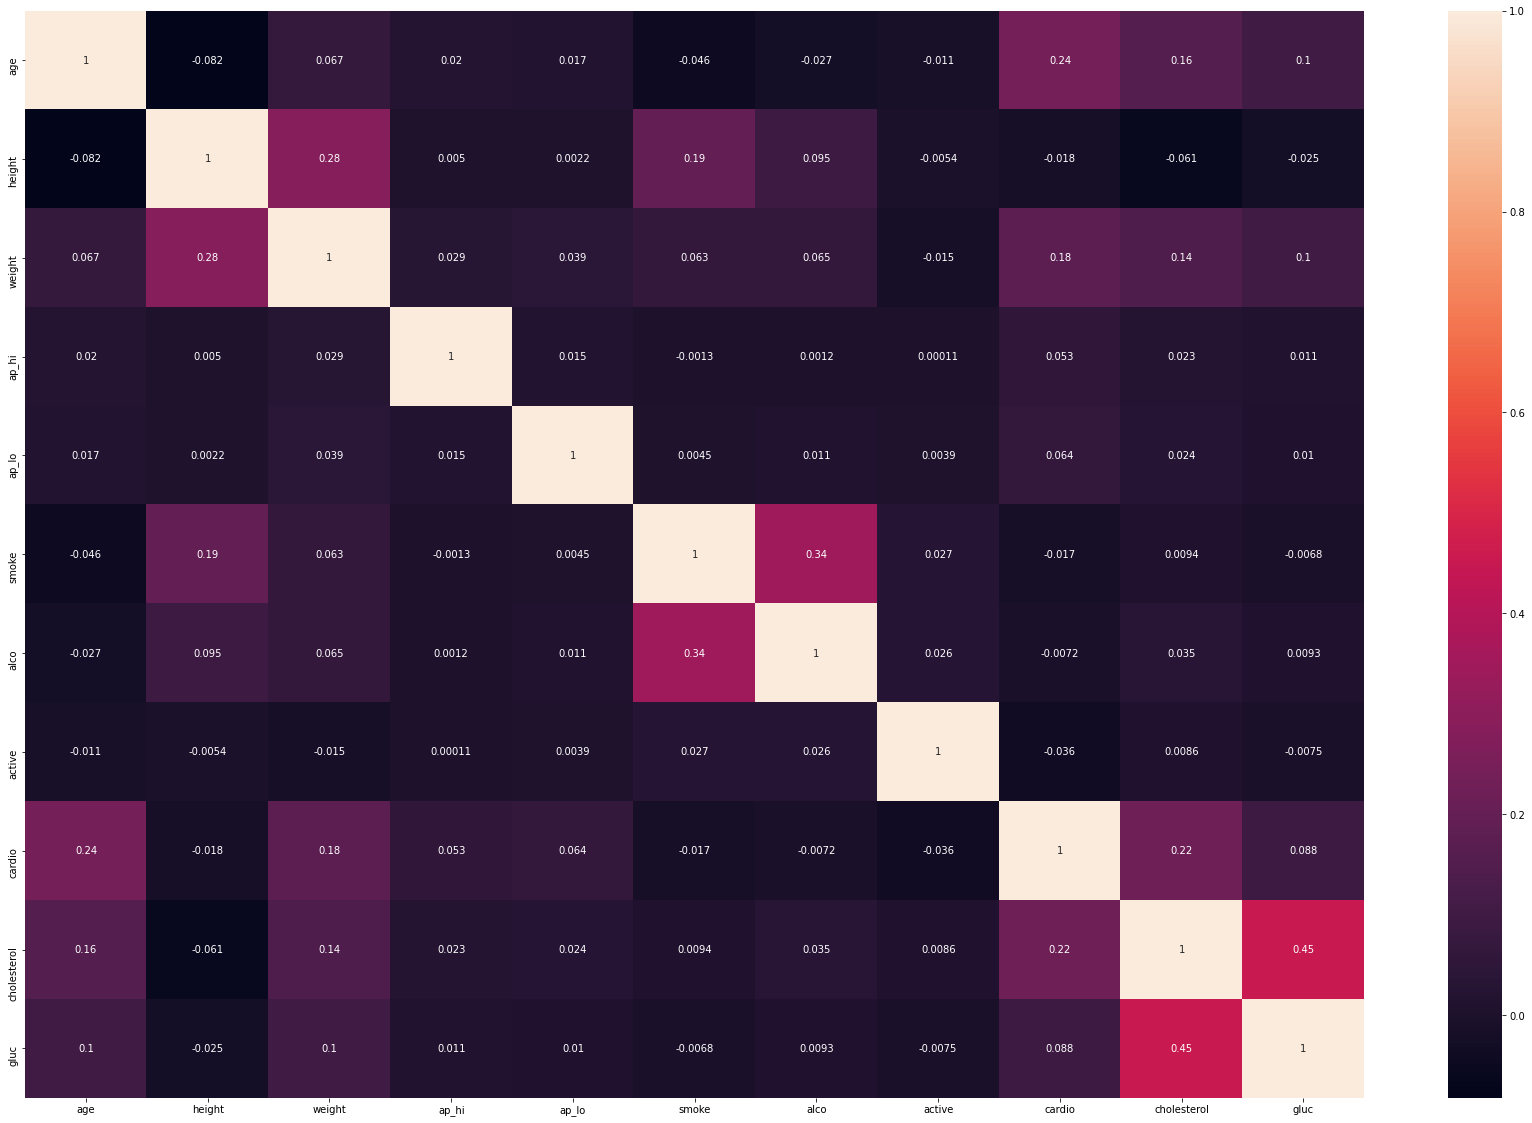

In [33]:
plt.figure(figsize=(30,20))
sns.heatmap(train[features_vif].corr(),annot=True)


In [0]:
logreg = LogisticRegression()


In [35]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred_log = logreg.predict(X_test)

In [37]:
print(accuracy_score(y_test,y_pred_log))

0.719889352439688


In [38]:
confusion_matrix(y_test,y_pred_log)

array([[8407, 2654],
       [3523, 7468]])

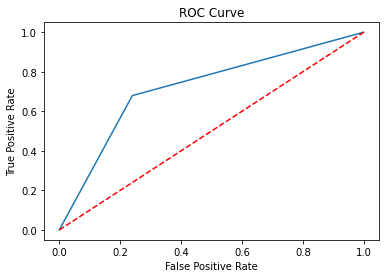

In [39]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_log)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
from sklearn.ensemble import RandomForestClassifier 

In [0]:
RFModel = RandomForestClassifier()

In [42]:
RFModel.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_pred_rf = RFModel.predict(X_test)

In [44]:
accuracy_score(y_test,y_pred_rf)

0.7140848902593869

In [0]:
xgb = XGBClassifier(learning_rate=0.01,n_estimators=500)

In [46]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred_xgb = xgb.predict(X_test)

In [48]:
xgb.score(X_test, y_test)

0.7356248866315981

In [0]:
pickle.dump(xgb,open('model.pkl','wb'))